In [1]:
import os
import cv2
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [2]:
class TreesDataset(Dataset):
    def __init__(self, data_links) -> None:
        self.X, self.Y = readData(data_links)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (self.X[index], self.Y[index])


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(3264, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
def create_datalinks(root_dir):
    data_links = os.listdir(root_dir)
    data_links = [root_dir + "/" + x for x in data_links]
    return data_links

def preprocess(img):
    scale_percent = 10
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resized = torchvision.transforms.functional.to_tensor(resized)
    return resized

def readData(data_links):
    x, y = [], []
    for link in data_links:
        img = cv2.imread(link, cv2.IMREAD_COLOR)
        img = preprocess(img)
        if("ground" in link):
            label = 1
        elif("AS12" in link):
            label = 0
        else:
            label = 0
        x.append(img)
        y.append(label)

    return x, y

In [4]:
links_3_plus_ground = create_datalinks("new_data/AS12_3") + create_datalinks("new_data/ground")

dataset = TreesDataset(links_3_plus_ground)

train_set, test_set = random_split(dataset, [300, 50], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=2)
testloader = DataLoader(test_set, batch_size=10, shuffle=True, num_workers=2)

classes = ('tree', 'ground')
epochs_num = 15

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:


for epoch in range(epochs_num):
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 10 == 0:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

        writer.add_scalar("Loss/train", loss.item(), i + epoch)
        writer.add_scalar("Accuracy/train", correct/total, i + epoch)

print('Finished Training')

[1,     1] loss: 0.074
[1,    11] loss: 0.725
[1,    21] loss: 0.695
[2,     1] loss: 0.063
[2,    11] loss: 0.606
[2,    21] loss: 0.594
[3,     1] loss: 0.071
[3,    11] loss: 0.405
[3,    21] loss: 0.477
[4,     1] loss: 0.015
[4,    11] loss: 0.327
[4,    21] loss: 0.484
[5,     1] loss: 0.052
[5,    11] loss: 0.486
[5,    21] loss: 0.370
[6,     1] loss: 0.014
[6,    11] loss: 0.454
[6,    21] loss: 0.317
[7,     1] loss: 0.052
[7,    11] loss: 0.434
[7,    21] loss: 0.467
[8,     1] loss: 0.051
[8,    11] loss: 0.438
[8,    21] loss: 0.457
[9,     1] loss: 0.071
[9,    11] loss: 0.422
[9,    21] loss: 0.358
[10,     1] loss: 0.013
[10,    11] loss: 0.447
[10,    21] loss: 0.373
[11,     1] loss: 0.052
[11,    11] loss: 0.314
[11,    21] loss: 0.387
[12,     1] loss: 0.037
[12,    11] loss: 0.437
[12,    21] loss: 0.395
[13,     1] loss: 0.013
[13,    11] loss: 0.431
[13,    21] loss: 0.423
[14,     1] loss: 0.017
[14,    11] loss: 0.466
[14,    21] loss: 0.371
[15,     1] loss: 0

In [6]:
correct = 0
total = 0
i=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        writer.add_scalar("Accuracy/test", correct/total, i + epoch)
        writer.add_scalar("Loss/test", loss.item(), i + epoch)
        i += 1

print('Accuracy : %d %%' % (100 * correct / total))

Accuracy : 84 %


In [7]:

images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(net, images)
writer.close()

In [19]:
multi = create_datalinks("new_data/multi")
multiset = TreesDataset(multi)
multiloader = DataLoader(multiset, batch_size=10, shuffle=True, num_workers=2)
criterion2 = nn.Softmax(dim=1)

In [28]:
correct = 0
total = 0
i=0
with torch.no_grad():
    for data in multiloader:
        images, labels = data
        outputs = net(images)
        loss = criterion2(outputs)
        loss2 = criterion(outputs, labels)
        print(loss)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        writer.add_scalar("Multi/Accuracy", correct/total, i)
        writer.add_scalar("Multi/Loss", loss2.item(), i + epoch)

        i += 1

print(correct/total)

tensor([[0.8594, 0.1406],
        [0.8276, 0.1724],
        [0.8850, 0.1150],
        [0.8887, 0.1113],
        [0.8737, 0.1263],
        [0.8814, 0.1186],
        [0.8911, 0.1089],
        [0.8364, 0.1636],
        [0.8846, 0.1154],
        [0.8726, 0.1274]])
tensor([[0.8452, 0.1548],
        [0.8533, 0.1467],
        [0.8536, 0.1464],
        [0.8593, 0.1407],
        [0.8557, 0.1443],
        [0.8811, 0.1189],
        [0.8727, 0.1273],
        [0.8529, 0.1471],
        [0.9053, 0.0947],
        [0.8824, 0.1176]])
tensor([[0.8593, 0.1407],
        [0.8952, 0.1048],
        [0.8780, 0.1220],
        [0.8724, 0.1276],
        [0.8451, 0.1549],
        [0.8424, 0.1576],
        [0.8332, 0.1668],
        [0.8567, 0.1433],
        [0.8487, 0.1513],
        [0.8839, 0.1161]])
tensor([[0.8759, 0.1241],
        [0.8340, 0.1660],
        [0.9141, 0.0859],
        [0.9075, 0.0925],
        [0.8674, 0.1326],
        [0.8431, 0.1569],
        [0.8933, 0.1067],
        [0.8475, 0.1525],
        [

In [44]:
from IPython.display import Image
from torchvision import models
from torchsummary import summary
from matplotlib import pyplot

In [38]:
summary(net, (3, 80, 60))
link = "new_data/AS12_3/AS12_3_1.png"

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 76, 56]             456
         MaxPool2d-2            [-1, 6, 38, 28]               0
            Conv2d-3           [-1, 16, 34, 24]           2,416
         MaxPool2d-4           [-1, 16, 17, 12]               0
            Linear-5                  [-1, 120]         391,800
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 405,006
Trainable params: 405,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.37
Params size (MB): 1.54
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


torch.Size([1, 6, 28, 38])


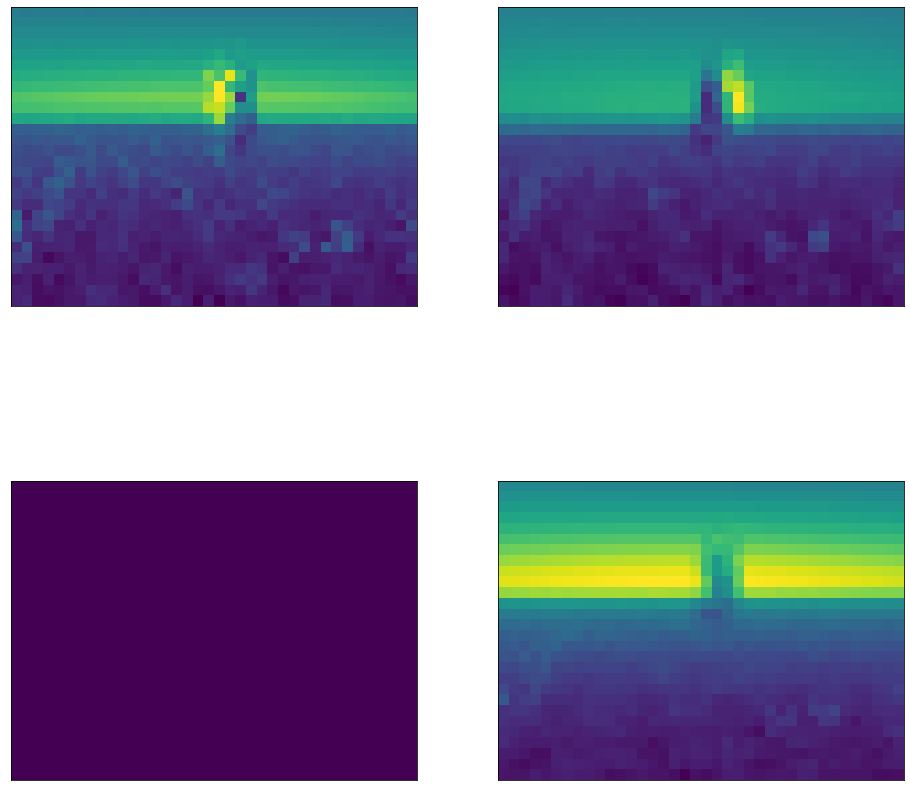

In [60]:
img = cv2.imread(link, cv2.IMREAD_COLOR)
img = preprocess(img)
img = img.view(1, 3, 60, 80)

output = net.pool(F.relu(net.conv1(img)))
print(output.size())

square = 2
ix = 1
pyplot.figure(figsize=(16, 16))
with torch.no_grad():
    for _ in range(square):
        for _ in range(square):
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(output[0, ix-1, :, :])
            ix += 1

pyplot.show()

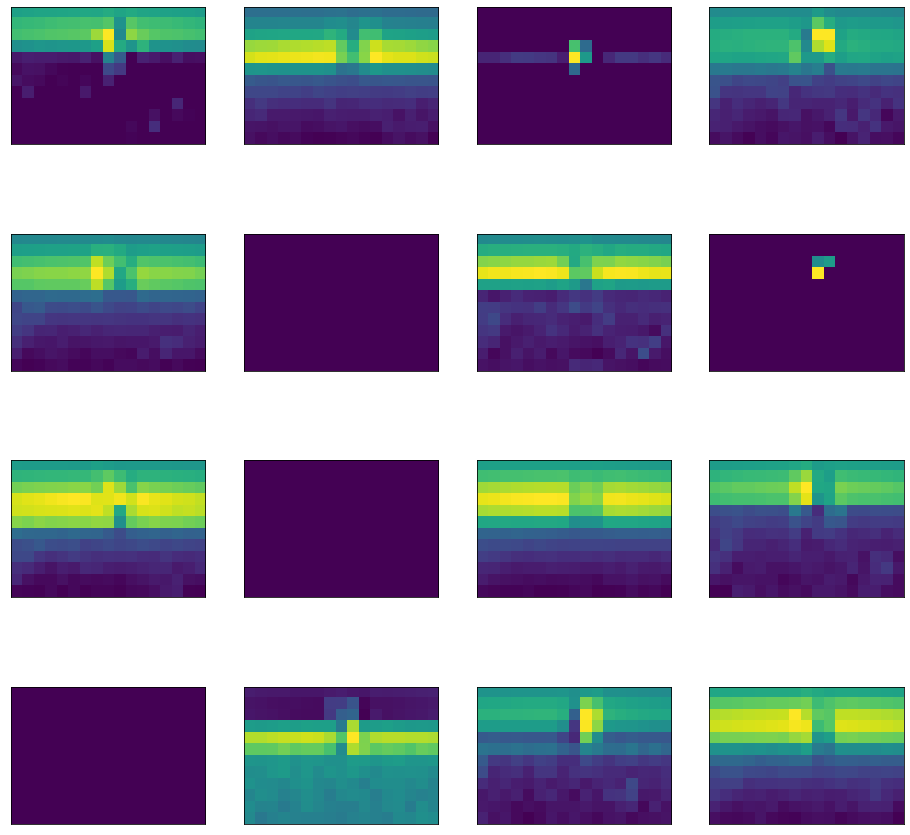

In [57]:
img = cv2.imread(link, cv2.IMREAD_COLOR)
img = preprocess(img)
img = img.view(1, 3, 60, 80)

output = net.pool(F.relu(net.conv1(img)))
output = net.pool(F.relu(net.conv2(output)))
output.size()

square = 4
ix = 1
pyplot.figure(figsize=(16, 16))
with torch.no_grad():
    for _ in range(square):
        for _ in range(square):
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(output[0, ix-1, :, :])
            ix += 1

pyplot.show()